In [1]:
path_to_muograph = "../"
import sys
sys.path.insert(1, path_to_muograph)

![alternative text](../images/muograph_logo.png)


**<h1><center>Tracking: tutorial</center></h1>**

The `TrackingMST` class is used to process **muon tracks** in the context of m**uon scattering tomography**. 

It combines the tracking **feature** of **muons** detected **before** and **after** the **volume of interest** and compute features relevant to **muon scattering tomography** reconstruction algorithms such as **scattering angle**.


The initialization is done by providing 2 instances of the `Tracking` class: 

- The **incoming muons** (muons detected **before** interaction with the volume of interest).

-  The **outgoing muons** (muons detected **after** interaction with the volume of interest).

First, let's gather the **incoming muon hits**. In the input data file, **panels** are **labeled** from **top to bottom**: 

 - **Labels 0, 1, 2** correspond to the **detector panels** placed **before** the **volume of interest**.

 - **Labels 3, 4, 5** correspond to the **detector panels** placed **after**.

In [2]:
csv_file = '../muograph/data/iron_barrel/barrel_and_cubes_scattering.csv'

from muograph.hits.hits import Hits

hits_in = Hits(
    csv_filename = csv_file,  # The csv file
    plane_labels = (0, 1, 2),  # Include hits from first planes 0, 1 and 2
    input_unit = "mm",  # The distance unit in the csv file.
    spatial_res = (1.0, 1.0, 0.),  # The spatial resolution along x, y and z in mm.
    efficiency = 0.90,
)
hits_in

GPU is not available. Using CPU
MPS is available. Using  mps


Collection of hits from 137,033 muons on 3 detector panels,
 with spatial resolution [1.00, 1.00, 0.00] mm along x, y, z, with panel efficiency of 90.0%.

In [3]:
hits_out = Hits(
    csv_filename = csv_file,  # The csv file
    plane_labels = (3, 4, 5),  # Include hits from first planes 0, 1 and 2
    input_unit = "mm",  # The distance unit in the csv file.
    spatial_res = (1.0, 1.0, 0.),  # The spatial resolution along x, y and z in mm.
    efficiency = 0.90,
)
hits_out

Collection of hits from 137,033 muons on 3 detector panels,
 with spatial resolution [1.00, 1.00, 0.00] mm along x, y, z, with panel efficiency of 90.0%.

We can now initialize the respective `Tracking`:

In [4]:
from muograph.tracking.tracking import Tracking

tracks_in = Tracking(label="above", hits=hits_in)
tracks_out = Tracking(label="below", hits=hits_out)

tracks_in, tracks_out

/Users/vischia/workarea_temp/muography/muograph/tutorials/../muograph/tracking/tracking.py:167: UserWarning: The operator 'aten::linalg_svd' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  _, _, vh = torch.linalg.svd(centered_hits_chunk, full_matrices=False)  # vh shape: (chunk_size, 3, 3)


(Collection of tracks from 137,033 muons 
  with angular resolution = 0.13 deg,
 Collection of tracks from 137,033 muons 
  with angular resolution = 0.13 deg)

The `TrackingMST` class **takes** the following **arguments**:

- `trackings (Optional[Tuple[Tracking, Tracking]])`: instances of the Tracking class
for the incoming muon tracks (Tracking.label = 'above') and outgoing tracks
(Tracking.label = 'below')


- `output_dir (Optional[str])`: Path to a directory where to save TrackingMST attributes
in a hdf5 file.

In [5]:
output_dir = "../output_test/"

from muograph.tracking.tracking import TrackingMST
mst = TrackingMST(trackings=(tracks_in, tracks_out))
mst

Collection of tracks from 72,643 muons 
 with average angular resolution = 0.13 deg
 with tracking efficiency = 53.01 %

### **Efficiency**

**Efficiencies** of the **incoming** and **outgoing** **tracks** (`tracks_in.tracks_eff` and `tracks_out.tracks_eff`) are **combined** to compute the event-wise efficiency `mst.muon_eff`.

In [6]:
tracks_in.tracks_eff, tracks_out.tracks_eff

(tensor([1, 1, 1,  ..., 1, 1, 1], device='mps:0'),
 tensor([0, 1, 1,  ..., 1, 1, 0], device='mps:0'))

If both `tracks_in.tracks_eff` and `tracks_out.tracks_eff` = 1, `mst.muon_eff` is set to `True`. Otherwise, it is set to `False`.

Only muons with `muon_eff == True` are kept. 

In [7]:
(tracks_in.tracks_eff.bool() & tracks_out.tracks_eff.bool()).sum(), mst.muon_eff.sum()

(tensor(72643, device='mps:0'), tensor(72643, device='mps:0'))

AS expected, the resulting **tracking efficiency** is the **product** of the **incoming** and **outgoing** tracks **efficiency**.

In [8]:
tracks_in.tracking_eff * tracks_out.tracking_eff, mst.tracking_eff

(0.5301744394138662, 0.5301131844154328)

The `TrackingMST` class **combines** the **features** of both `Tracking` instances:

### **Tracks**

In [9]:
event = 8114
f"Muon #{event} incoming direction px, py, pz = {mst.tracks_in[event, 0]:.3f}, {mst.tracks_in[event, 1]:.3f}, {mst.tracks_in[event, 2]:.3f}"

'Muon #8114 incoming direction px, py, pz = -0.249, -0.241, -0.938'

In [10]:
f"Muon #{event} outgoing direction px, py, pz = {mst.tracks_out[event, 0]:.3f}, {mst.tracks_in[event, 1]:.3f}, {mst.tracks_in[event, 2]:.3f}"

'Muon #8114 outgoing direction px, py, pz = -0.253, -0.241, -0.938'

### **Points**

In [11]:
f"Muon #{event} incoming position x, y, z = {mst.points_in[event, 0]:.3f}, {mst.points_in[event, 1]:.3f}, {mst.points_in[event, 2]:.3f} [mm]"

'Muon #8114 incoming position x, y, z = 244.357, 455.554, -399.995 [mm]'

In [12]:
f"Muon #{event} incoming position x, y, z = {mst.points_out[event, 0]:.3f}, {mst.points_out[event, 1]:.3f}, {mst.points_out[event, 2]:.3f} [mm]"

'Muon #8114 incoming position x, y, z = -184.964, 50.199, -1999.993 [mm]'

### **Angles**

**Angles** are expressed in **radiants**.

#### **Zenith angles**

In [13]:
f"Muon #{event} has incoming zenith angle = {mst.theta_in[event]:.3f} [rad]"

'Muon #8114 has incoming zenith angle = 0.354 [rad]'

In [14]:
f"Muon #{event} has outgoing zenith angle = {mst.theta_out[event]:.3f} [rad]"


'Muon #8114 has outgoing zenith angle = 0.355 [rad]'

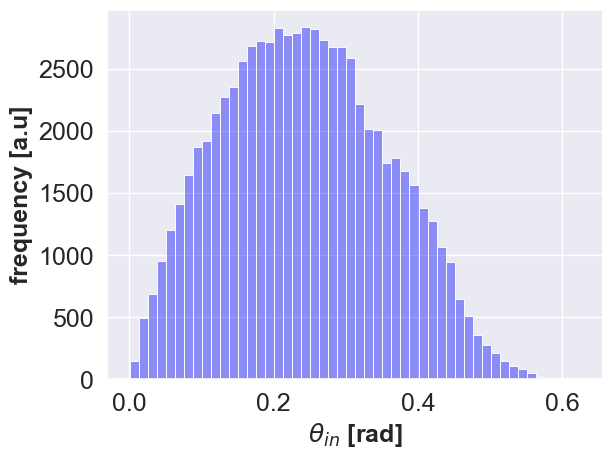

In [15]:
from muograph.plotting.plotting import plot_hist
plot_hist(mst.theta_in, xlabel = r"$\theta_{in}$ [rad]")

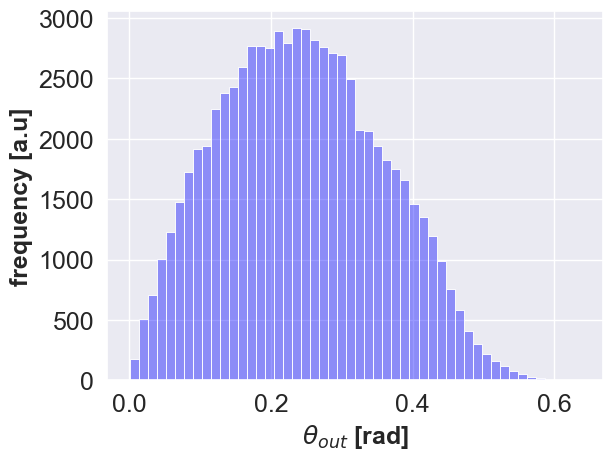

In [16]:
from muograph.plotting.plotting import plot_hist
plot_hist(mst.theta_out, xlabel = r"$\theta_{out}$ [rad]" )

#### **Scattering angle**

The muon scatteing angle $\Delta\theta$ is computed from the inmcopming and outgoing tracks direction $\overrightarrow{T}_{in} = (p_{x, in}, p_{y, in}, p_{z, in})$ and $\overrightarrow{T}_{out} = (p_{x, out}, p_{y, out}, p_{z, out})$:

$$
\Delta\theta = cos^{-1}\left(\frac{\overrightarrow{T}_{in} \cdot \overrightarrow{T}_{out}}{|\overrightarrow{T}_{in}| |\overrightarrow{T}_{out}|}\right)
$$

In [17]:
f"Muon #{event} has scattering angle = {mst.dtheta[event]:.4f} [rad]"


'Muon #8114 has scattering angle = 0.0054 [rad]'

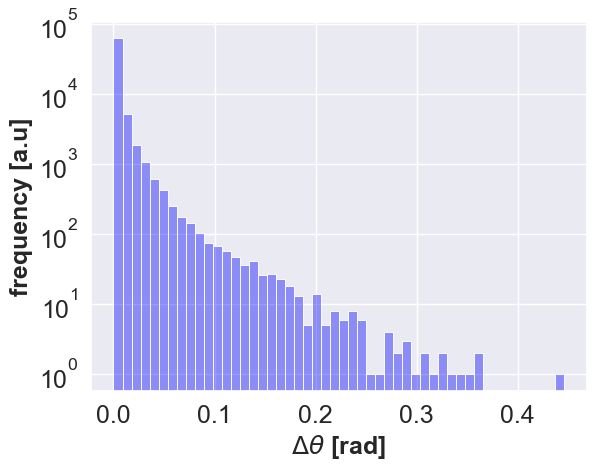

In [18]:
plot_hist(mst.dtheta, xlabel = r"$\Delta\theta$ [rad]",  logy=True)

#### **Summary**

The **zenith angle**, **energy** and **scattering angle distributions** can be **plotted** using the `plot_muon_features` function. 

If a file name is provided as `figname`, the **figure** is **saved** as the desired location.

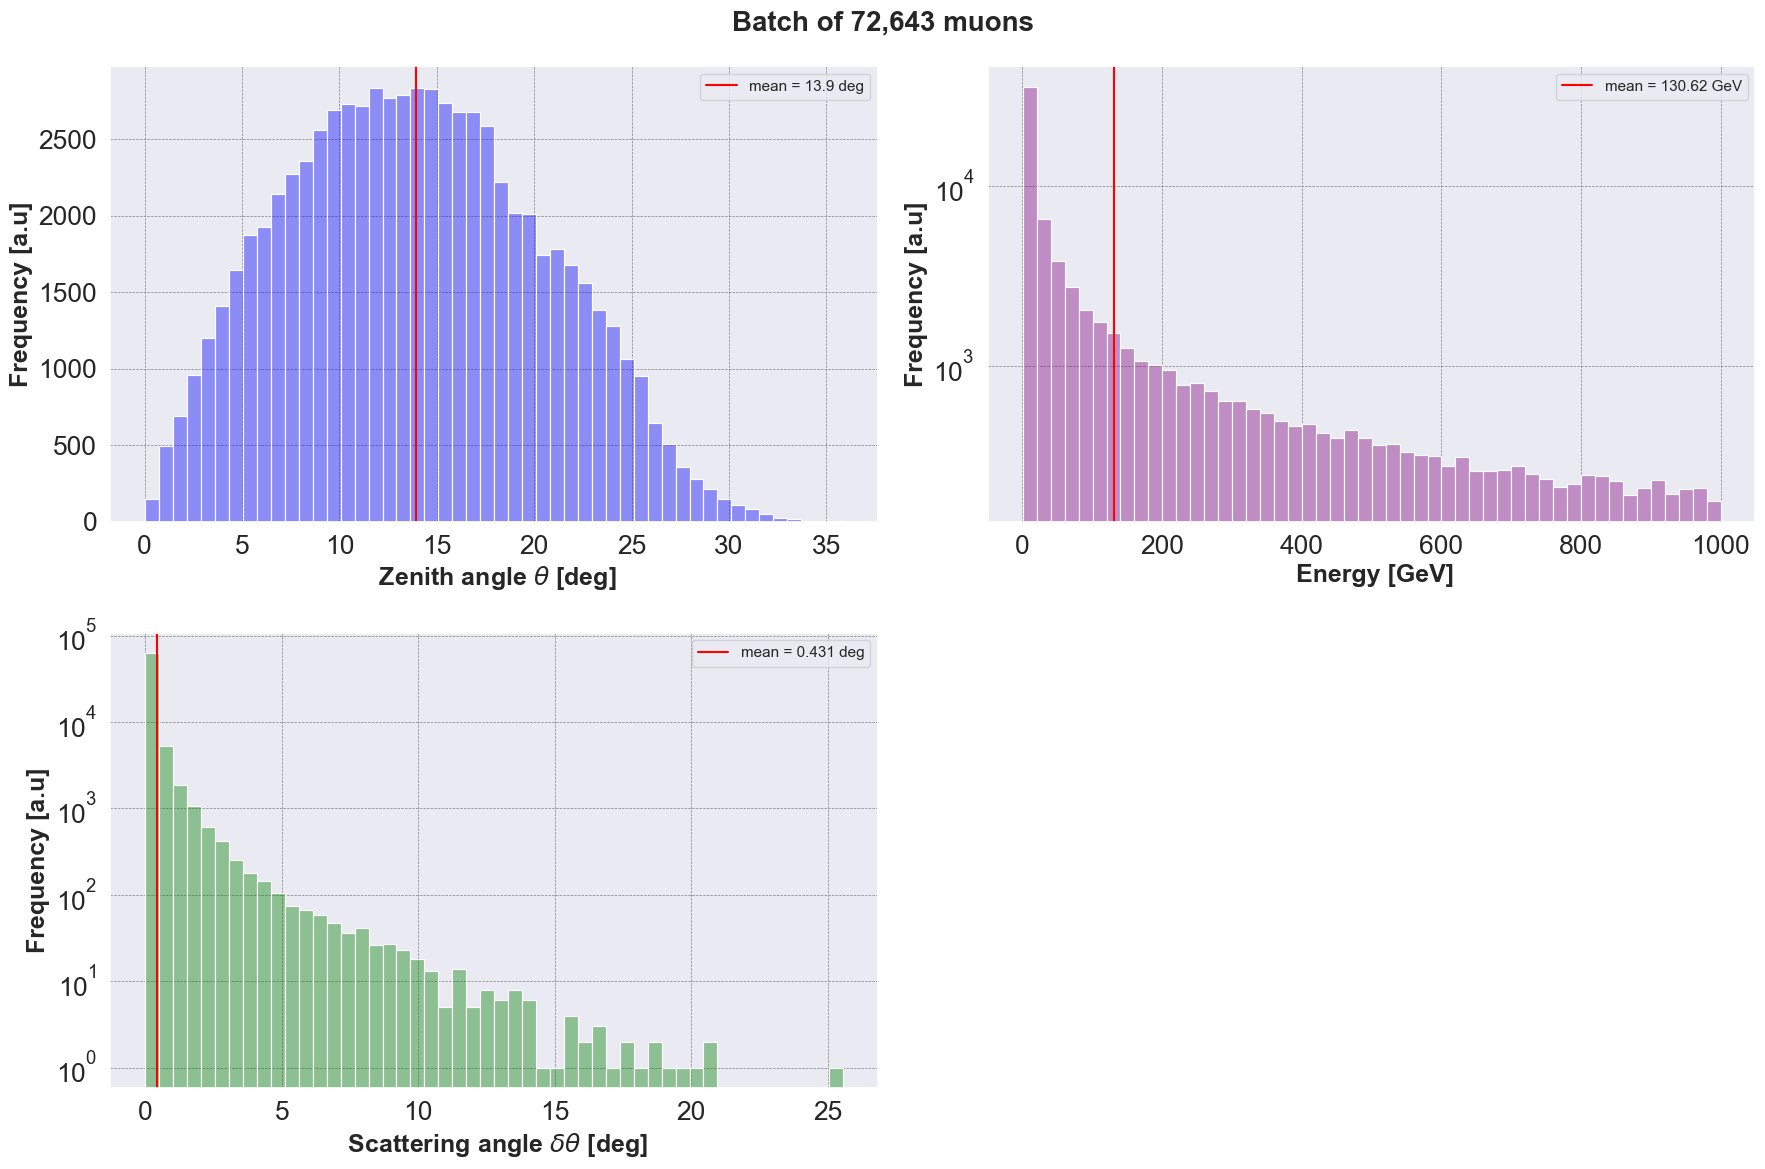

In [19]:
mst.plot_muon_features(figname=output_dir+"theta_dtheta_E")

#### **Plot event**

The **fitted tracks** can be **plotted** using the `TrackingMST.plot_tracking_event()` function. 


Similarly to `Tracking.plot_tracking_event()` it displays the fitted points and tracks on a 2D projection.

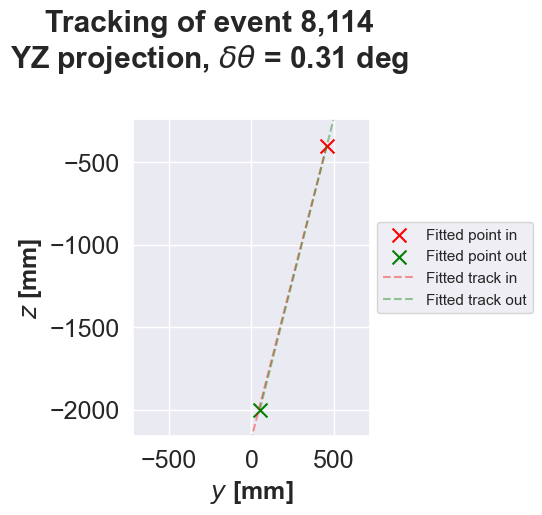

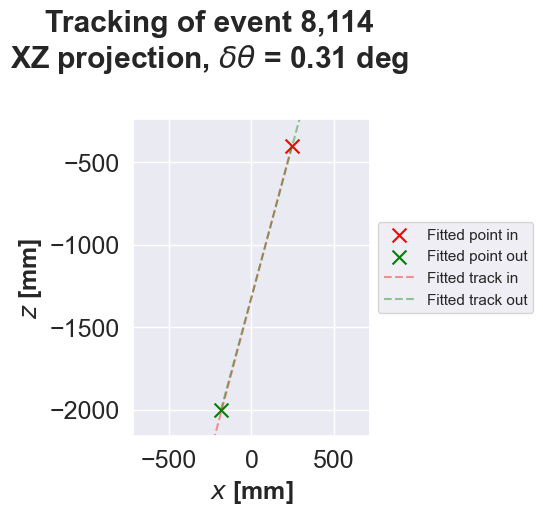

In [20]:
mst.plot_tracking_event(
    proj="YZ", # The desired projection
    event=event, # The event to plot
    figname="../output_test/tracking_event_mst_YZ", # Name of the figure to save
    )

mst.plot_tracking_event(
    proj="XZ", # The desired projection
    event=event,  # The event to plot
    figname="../output_test/tracking_event_mst_XZ", # Name of the figure to save
    )

If an instance of the `Volume` class interest is provided, the **volume of interest** gets represented on the plot: 

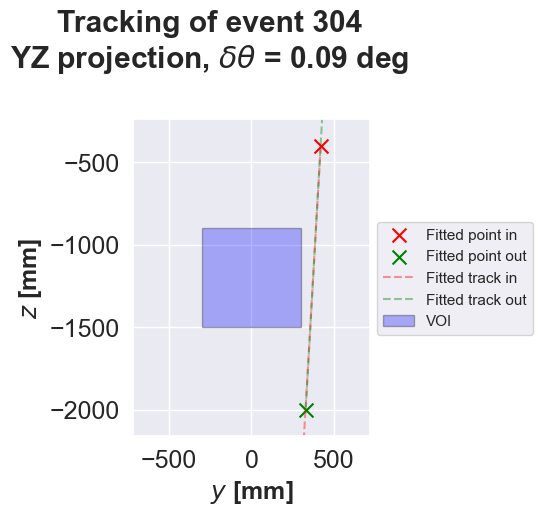

In [23]:
from muograph.volume.volume import Volume
import numpy as np
voi = Volume(
    position = (0, 0, -1200),
    dimension = (1000, 600, 600),
    voxel_width = (20, 10, 20))

mst.plot_tracking_event(
    voi=voi, # The Volume of interest
    proj="YZ",
    event=np.random.randint(10000),
    figname="../output_test/tracking_event_mst_voi")